Generating CM1 comparisons with tuned parameters...

Found 28 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 17
Processing same-compound comparisons

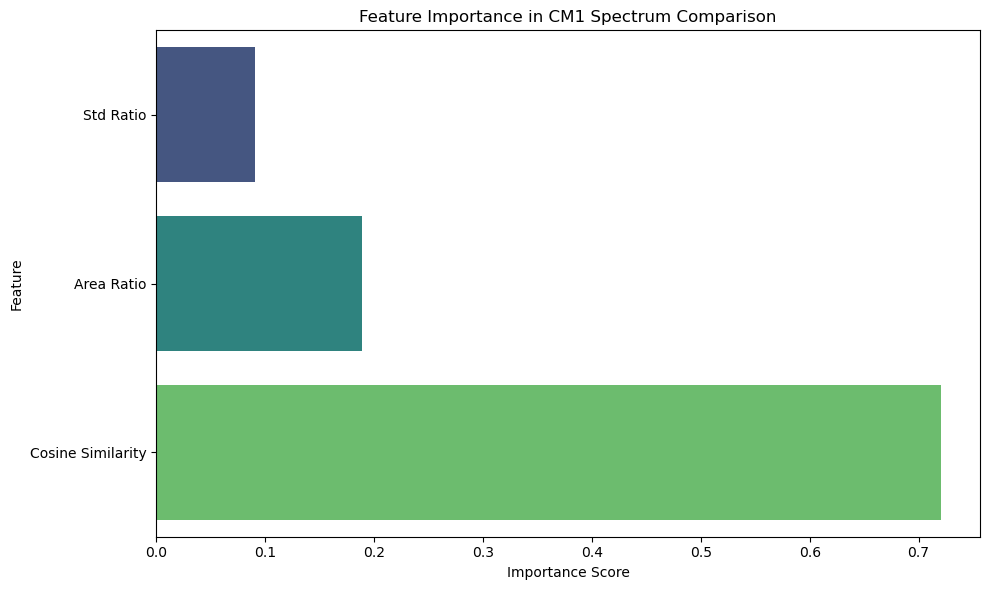


Feature Importance Rankings:
Cosine Similarity    0.7203
Area Ratio           0.1888
Std Ratio            0.0909

Confusion Matrix:


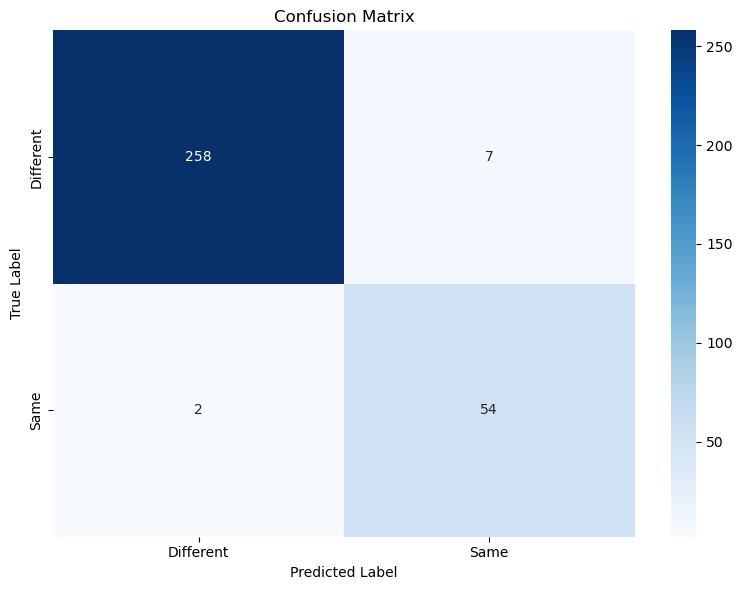


Tuned model and scaler saved!


In [8]:
#cm1


# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Function to read mass spectra data from CSV
def load_spectrum(filepath):
    """Reads CSV file containing mass spectrum data
    Returns: m/z values and intensity values"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)  # Skip header row
        mz = spectrum['X(Thompsons)'].values         # Mass/charge values
        intensities = spectrum['Y(Counts)'].values    # Intensity values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

# Function to preprocess and align two spectra
def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Aligns two spectra for comparison by:
    1. Creating common m/z axis
    2. Interpolating intensities
    3. Normalizing intensities to [0,1] range"""
    try:
        # Find overlapping m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create uniform m/z axis with 1000 points
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Interpolate intensities to match common m/z axis
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities to [0,1] range
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

# Function to calculate similarity features between two spectra
def calculate_similarity_features(mz, int1, int2):
    """Calculates 3 similarity metrics between spectra:
    1. Cosine similarity: angle between spectra vectors
    2. Area ratio: ratio of areas under curves
    3. Standard deviation ratio: ratio of intensity spreads"""
    try:
        # Calculate cosine similarity (angle between vectors)
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        # Calculate area ratios using trapezoidal integration
        area1 = np.trapz(int1, mz)
        area2 = np.trapz(int2, mz)
        area_ratio = min(area1/area2, area2/area1) if area1 > 0 and area2 > 0 else 0
        
        # Calculate standard deviation ratios
        std_ratio = min(np.std(int1)/np.std(int2), np.std(int2)/np.std(int1)) if np.std(int1) > 0 and np.std(int2) > 0 else 0
        
        features = {
            'cosine_similarity': cosine_sim,
            'area_ratio': area_ratio,
            'std_ratio': std_ratio
        }
        
        # Check for invalid values
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

# Function to check if compound files exist
def check_compound_existence(base_path, compound_num):
    """Checks if at least one spectrum file exists for a compound"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

# Main function to generate comparison dataset
def generate_balanced_comparisons(base_path, debug=False):
    """Creates balanced dataset of spectrum comparisons:
    - Positive class (y=1): Same compound comparisons
    - Negative class (y=0): Different compound comparisons"""
    X = []  # Features
    y = []  # Labels
    comparisons = []  # File pairs
    same_count = 0    # Count of same-compound pairs
    diff_count = 0    # Count of different-compound pairs
    
    # Find all existing compounds
    existing_compounds = []
    for compound_i in range(1, 29):  # CM1 has 28 compounds
        if check_compound_existence(base_path, compound_i):
            existing_compounds.append(compound_i)
    
    if debug:
        print(f"\nFound {len(existing_compounds)} compounds")
        
    # Generate same-compound comparisons
    for compound_i in existing_compounds:
        if debug:
            print(f"Processing same-compound comparisons for compound {compound_i}")
            
        # Compare first 5 spectra of each compound
        for i in range(1, 5):
            for j in range(i + 1, 6):
                file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                
                if not os.path.exists(file1) or not os.path.exists(file2):
                    continue
                    
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((file1, file2))
                    same_count += 1
    
    # Generate different-compound comparisons
    for idx, compound_i in enumerate(existing_compounds[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound_i}")
            
        # Compare with next 2 compounds for balance
        for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
            for i in range(1, 6):
                for j in range(1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                    
                    features = calculate_similarity_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(0)  # Different compounds
                        comparisons.append((file1, file2))
                        diff_count += 1
    
    # Print dataset statistics
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

# Function to visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    """Creates and plots confusion matrix for model evaluation"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Different', 'Same'],
                yticklabels=['Different', 'Same'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return cm

# Main execution function
def main():
    # Set data path
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1'
    
    # Generate dataset
    print("Generating CM1 comparisons with tuned parameters...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split data into train/test sets and scale features
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create XGBoost model with optimized parameters
        model = xgb.XGBClassifier(
            # Tree parameters
            max_depth=4,
            min_child_weight=2,
            gamma=0.1,
            
            # Sampling parameters
            subsample=0.9,
            colsample_bytree=0.9,
            
            # Learning parameters
            learning_rate=0.005,
            n_estimators=300,
            
            # Class weight for imbalance
            scale_pos_weight=4,
            
            # Regularization
            reg_lambda=0.8,
            reg_alpha=0.1,
            
            # Other settings
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        # Perform cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate model performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Analyze feature importance
        feature_names = ['Cosine Similarity', 'Std Ratio', 'Area Ratio']
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM1 Spectrum Comparison')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature rankings
        print("\nFeature Importance Rankings:")
        for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
            print(f"{name:20} {imp:.4f}")
        
        # Show confusion matrix
        print("\nConfusion Matrix:")
        cm = plot_confusion_matrix(y_test, y_pred)
        
        # Save model and scaler
        try:
            model.save_model('cm1_comparison_model_tuned.json')
            joblib.dump(scaler, 'cm1_scaler_tuned.joblib')
            print("\nTuned model and scaler saved!")
        except Exception as e:
            print(f"Error saving model: {str(e)}")

# Execute main function if script is run directly
if __name__ == "__main__":
    main()



In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming you already have X and y from your generate_balanced_comparisons function
base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1'
X, y, comparisons = generate_balanced_comparisons(base_path)

# Create DataFrame with features
preprocessed_df = pd.DataFrame(X, columns=['cosine_similarity', 'area_ratio', 'std_ratio'])

# Add target variable
preprocessed_df['target'] = y

# Add file comparisons
preprocessed_df['file1'] = [comp[0] for comp in comparisons]
preprocessed_df['file2'] = [comp[1] for comp in comparisons]

# Display first few rows and basic info
print("\nFirst few rows of preprocessed data:")
print(preprocessed_df.head())

print("\nDataset Info:")
print(preprocessed_df.info())

print("\nSummary Statistics:")
print(preprocessed_df.describe())

# Check class distribution
print("\nClass Distribution:")
print(preprocessed_df['target'].value_counts(normalize=True))




Comparison Statistics:
Same compound comparisons: 280
Different compound comparisons: 1325
Class balance ratio (same/diff): 0.21

First few rows of preprocessed data:
   cosine_similarity  area_ratio  std_ratio  target  \
0           0.984924    0.945683   0.973246       1   
1           0.980782    0.960948   0.972200       1   
2           0.975066    0.958463   0.979874       1   
3           0.986696    0.930497   0.975069       1   
4           0.979656    0.990128   0.999756       1   

                                               file1  \
0  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...   
1  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...   
2  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...   
3  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...   
4  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...   

                                               file2  
0  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...  
1  /Users/ajibolaoluwatobiloba/Desktop/Mass spect...  

In [5]:

    
X_train_scaled, X_test_scaled, y_train, y_test, scaler = get_preprocessed_data(base_path)


Comparison Statistics:
Same compound comparisons: 280
Different compound comparisons: 1325
Class balance ratio (same/diff): 0.21


Generating CM2 comparisons with top features only...

Dataset Information:
Total compounds expected: 58
Compounds found: 57
Missing compounds: [42]

Processing compound 1

Processing compound 2

Processing compound 3

Processing compound 4

Processing compound 5

Processing compound 6

Processing compound 7

Processing compound 8

Processing compound 9

Processing compound 10

Processing compound 11

Processing compound 12

Processing compound 13

Processing compound 14

Processing compound 15

Processing compound 16

Processing compound 17

Processing compound 18

Processing compound 19

Processing compound 20

Processing compound 21

Processing compound 22

Processing compound 23

Processing compound 24

Processing compound 25

Processing compound 26

Processing compound 27

Processing compound 28

Processing compound 29

Processing compound 30

Processing compound 31

Processing compound 32

Processing compound 33

Processing compound 34

Processing compound 35

Processing compound 

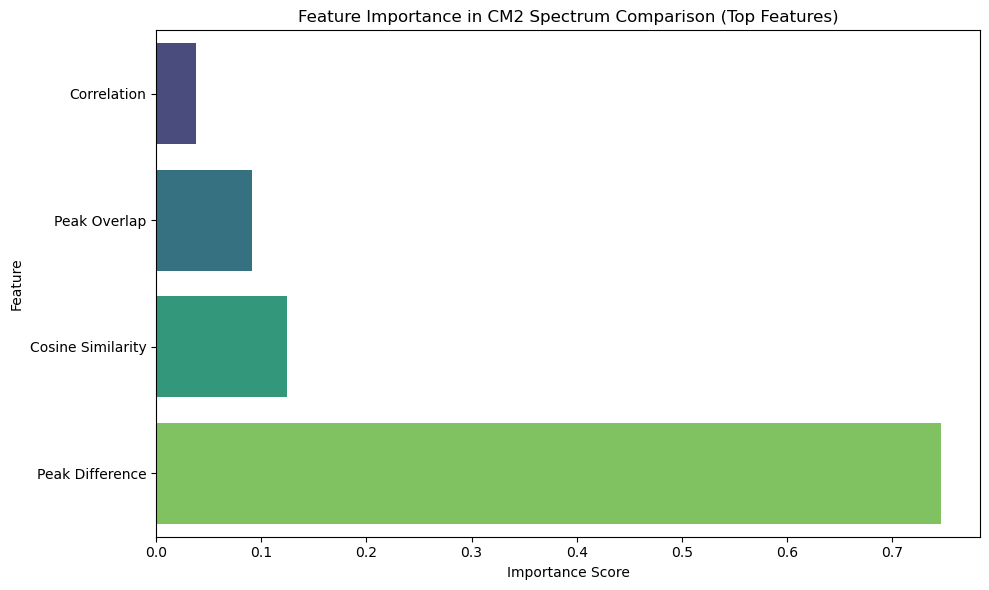


Feature Importance Rankings:
Peak Difference      0.7461
Cosine Similarity    0.1246
Peak Overlap         0.0916
Correlation          0.0377


In [16]:
#CM2

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra - top features only"""
    try:
        # Basic similarity measures
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        # Peak analysis
        peak_threshold1 = np.mean(int1) + np.std(int1)
        peak_threshold2 = np.mean(int2) + np.std(int2)
        peaks1 = int1 > peak_threshold1
        peaks2 = int2 > peak_threshold2
        
        peak_overlap = np.sum(np.logical_and(peaks1, peaks2)) / len(mz)
        peak_diff = np.sum(np.logical_xor(peaks1, peaks2)) / len(mz)
        
        features = {
            'peak_difference': peak_diff,
            'cosine_similarity': cosine_sim,
            'peak_overlap': peak_overlap,
            'correlation': correlation
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def main():
    # Set path for CM2
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2'
    
    # Generate comparisons
    print("Generating CM2 comparisons with top features only...")
    X, y, comparisons = generate_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Create model with same anti-overfitting measures
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        print("\nPerforming cross-validation...")
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance analysis
        feature_names = ['Peak Difference', 'Cosine Similarity', 'Peak Overlap', 'Correlation']
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM2 Spectrum Comparison (Top Features)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance rankings
        print("\nFeature Importance Rankings:")
        for idx, row in importance_df.iloc[::-1].iterrows():
            print(f"{row['Feature']:20} {row['Importance']:.4f}")
        
if __name__ == "__main__":
    main()

Generating balanced CM2 comparisons...

Found 57 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 17
Processing same-compound comparisons for compound

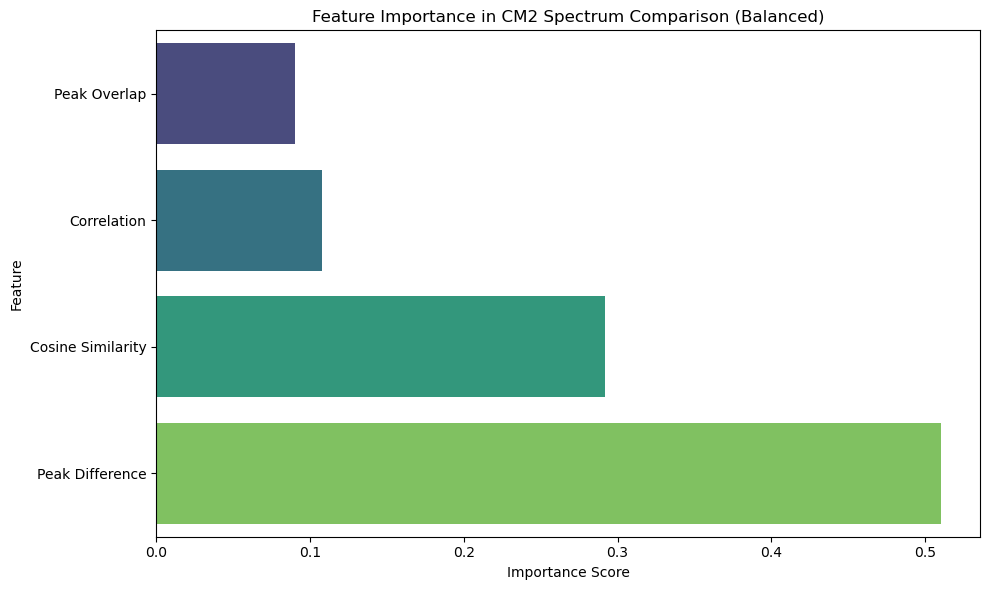


Feature Importance Rankings:
Peak Difference      0.5100
Cosine Similarity    0.2918
Correlation          0.1078
Peak Overlap         0.0904


In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra - using top features only"""
    try:
        # Basic similarity measures
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        # Peak analysis
        peak_threshold1 = np.mean(int1) + np.std(int1)
        peak_threshold2 = np.mean(int2) + np.std(int2)
        peaks1 = int1 > peak_threshold1
        peaks2 = int2 > peak_threshold2
        
        peak_overlap = np.sum(np.logical_and(peaks1, peaks2)) / len(mz)
        peak_diff = np.sum(np.logical_xor(peaks1, peaks2)) / len(mz)
        
        features = {
            'peak_difference': peak_diff,
            'cosine_similarity': cosine_sim,
            'peak_overlap': peak_overlap,
            'correlation': correlation
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def check_compound_existence(base_path, compound_num):
    """Check if a compound exists by looking for at least one valid file"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

def generate_balanced_comparisons(base_path, debug=False):
    """Generate more balanced pairwise comparisons"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # First, identify existing compounds
    existing_compounds = []
    for compound_i in range(1, 59):
        if check_compound_existence(base_path, compound_i):
            existing_compounds.append(compound_i)
    
    if debug:
        print(f"\nFound {len(existing_compounds)} compounds")
        
    # Same compound comparisons (using 5 samples)
    for compound_i in existing_compounds:
        if debug:
            print(f"Processing same-compound comparisons for compound {compound_i}")
            
        for i in range(1, 5):
            for j in range(i + 1, 6):
                file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                
                if not os.path.exists(file1) or not os.path.exists(file2):
                    continue
                    
                features = calculate_similarity_features(
                    *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                )
                
                if features is not None:
                    X.append(list(features.values()))
                    y.append(1)  # Same compound
                    comparisons.append((file1, file2))
                    same_count += 1
    
    # Different compound comparisons (comparing with multiple compounds)
    for idx, compound_i in enumerate(existing_compounds[:-1]):
        if debug:
            print(f"Processing different-compound comparisons for compound {compound_i}")
            
        # Compare with next 2 compounds
        for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
            for i in range(1, 6):
                for j in range(1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                    
                    features = calculate_similarity_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(0)  # Different compounds
                        comparisons.append((file1, file2))
                        diff_count += 1
    
    print("\nComparison Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    if len(X) == 0:
        print("No valid comparisons generated!")
        return None, None, None
        
    return np.array(X), np.array(y), comparisons

def main():
    # Set path for CM2
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2'
    
    # Generate balanced comparisons
    print("Generating balanced CM2 comparisons...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Create model with anti-overfitting measures
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        print("\nPerforming cross-validation...")
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance analysis
        feature_names = ['Peak Difference', 'Cosine Similarity', 'Peak Overlap', 'Correlation']
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM2 Spectrum Comparison (Balanced)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance rankings
        print("\nFeature Importance Rankings:")
        for idx, row in importance_df.iloc[::-1].iterrows():
            print(f"{row['Feature']:20} {row['Importance']:.4f}")
        
if __name__ == "__main__":
    main()

Generating CM3 comparisons (using only Cosine Similarity and Correlation)...

Found 49 compounds
Processing same-compound comparisons for compound 1
Processing same-compound comparisons for compound 2
Processing same-compound comparisons for compound 3
Processing same-compound comparisons for compound 4
Processing same-compound comparisons for compound 5
Processing same-compound comparisons for compound 6
Processing same-compound comparisons for compound 7
Processing same-compound comparisons for compound 8
Processing same-compound comparisons for compound 9
Processing same-compound comparisons for compound 10
Processing same-compound comparisons for compound 11
Processing same-compound comparisons for compound 12
Processing same-compound comparisons for compound 13
Processing same-compound comparisons for compound 14
Processing same-compound comparisons for compound 15
Processing same-compound comparisons for compound 16
Processing same-compound comparisons for compound 17
Processing 

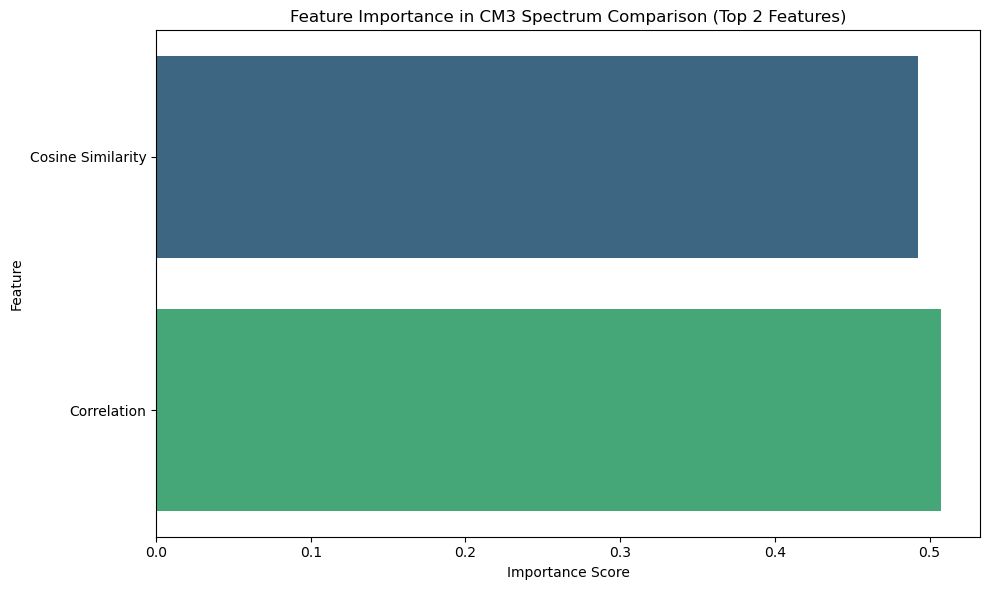


Feature Importance Rankings:
Correlation          0.5072
Cosine Similarity    0.4928

Simplified model and scaler saved!


In [21]:
#CM3
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None
def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra - using only top 2 features"""
    try:
        # Basic similarity measures only
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        features = {
            'cosine_similarity': cosine_sim,
            'correlation': correlation
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def main():
    # Set path for CM3
    base_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    
    # Generate comparisons
    print("Generating CM3 comparisons (using only Cosine Similarity and Correlation)...")
    X, y, comparisons = generate_balanced_comparisons(base_path, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Define cross-validation strategy
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Create model
        model = xgb.XGBClassifier(
            max_depth=3,
            learning_rate=0.01,
            n_estimators=200,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False,
            reg_lambda=1.0,
            reg_alpha=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            min_child_weight=3
        )
        
        # Perform cross-validation
        print("\nPerforming cross-validation...")
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train final model
        print("\nTraining final model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nTest Set Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        # Feature importance analysis
        feature_names = ['Cosine Similarity', 'Correlation']
        importance = model.feature_importances_
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in CM3 Spectrum Comparison (Top 2 Features)')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        # Print feature importance rankings
        print("\nFeature Importance Rankings:")
        for idx, row in importance_df.iloc[::-1].iterrows():
            print(f"{row['Feature']:20} {row['Importance']:.4f}")
        
        # Save model and scaler
        model.save_model('cm3_comparison_model_simplified.json')
        import joblib
        joblib.dump(scaler, 'cm3_scaler_simplified.joblib')
        print("\nSimplified model and scaler saved!")

if __name__ == "__main__":
    main()

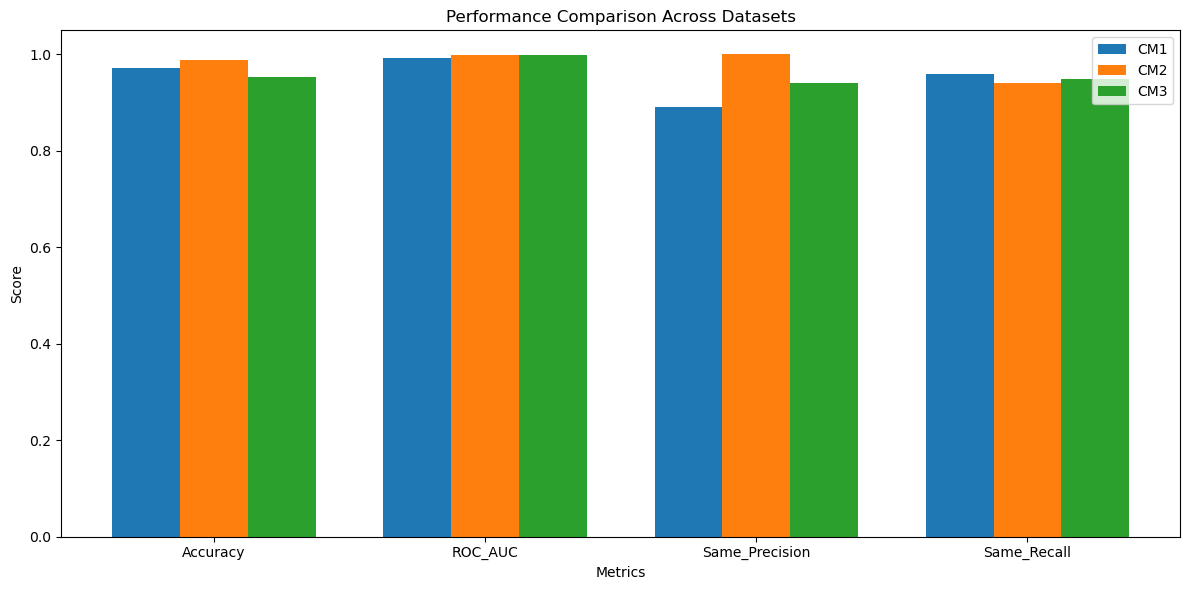

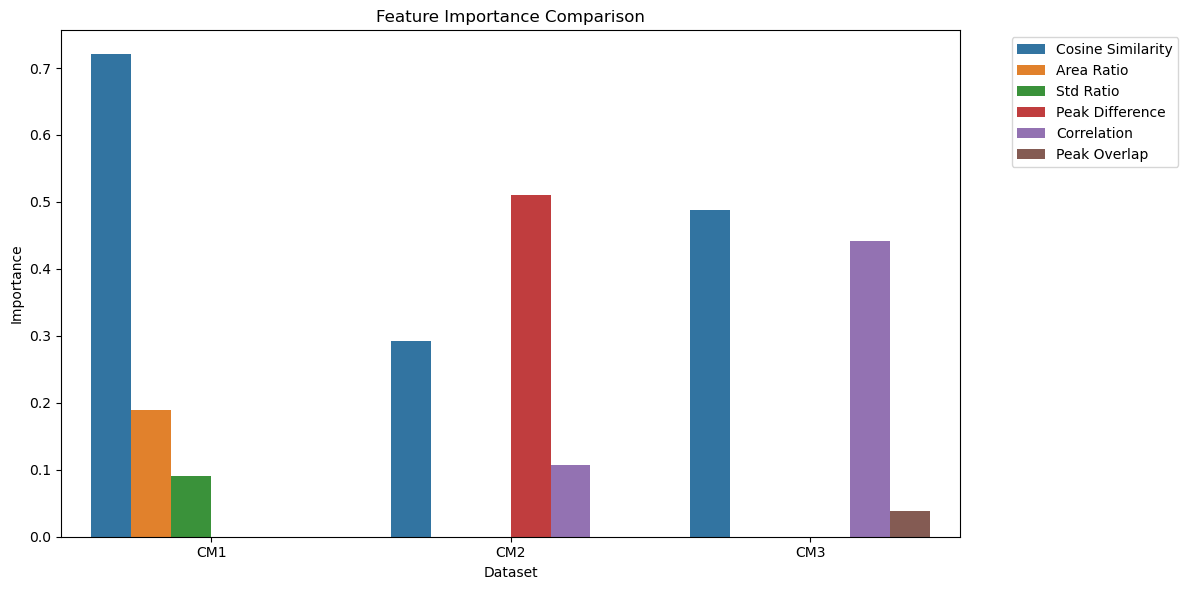

In [26]:
#model comparison
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Create comparison data
model_metrics = pd.DataFrame({
    'Dataset': ['CM1', 'CM2', 'CM3'],
    'Accuracy': [0.9720, 0.9895, 0.9533],
    'ROC_AUC': [0.9934, 0.9993, 0.9997],
    'Same_Precision': [0.89, 1.00, 0.94],
    'Same_Recall': [0.96, 0.94, 0.95],
    'Different_Precision': [0.99, 0.99, 0.99],
    'Different_Recall': [0.97, 1.00, 0.98]
})

# Create feature importance data
feature_importance = pd.DataFrame({
    'Dataset': ['CM1', 'CM1', 'CM1', 
               'CM2', 'CM2', 'CM2', 
               'CM3', 'CM3', 'CM3'],
    'Feature': ['Cosine Similarity', 'Area Ratio', 'Std Ratio',
                'Peak Difference', 'Cosine Similarity', 'Correlation',
                'Cosine Similarity', 'Correlation', 'Peak Overlap'],
    'Importance': [0.7203, 0.1888, 0.0909,
                  0.5100, 0.2918, 0.1078,
                  0.4884, 0.4417, 0.0391]
})

# Plot performance metrics
plt.figure(figsize=(12, 6))
metrics_to_plot = ['Accuracy', 'ROC_AUC', 'Same_Precision', 'Same_Recall']
bar_positions = np.arange(len(metrics_to_plot))
width = 0.25

for i, dataset in enumerate(['CM1', 'CM2', 'CM3']):
    values = [model_metrics.loc[model_metrics['Dataset'] == dataset, metric].values[0] 
              for metric in metrics_to_plot]
    plt.bar(bar_positions + i*width, values, width, label=dataset)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Performance Comparison Across Datasets')
plt.xticks(bar_positions + width, metrics_to_plot)
plt.legend()
plt.tight_layout()
plt.show()

# Plot feature importance
plt.figure(figsize=(12, 6))
g = sns.barplot(data=feature_importance, x='Dataset', y='Importance', hue='Feature')
plt.title('Feature Importance Comparison')
plt.xticks(rotation=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

CM1 Feature Distributions:


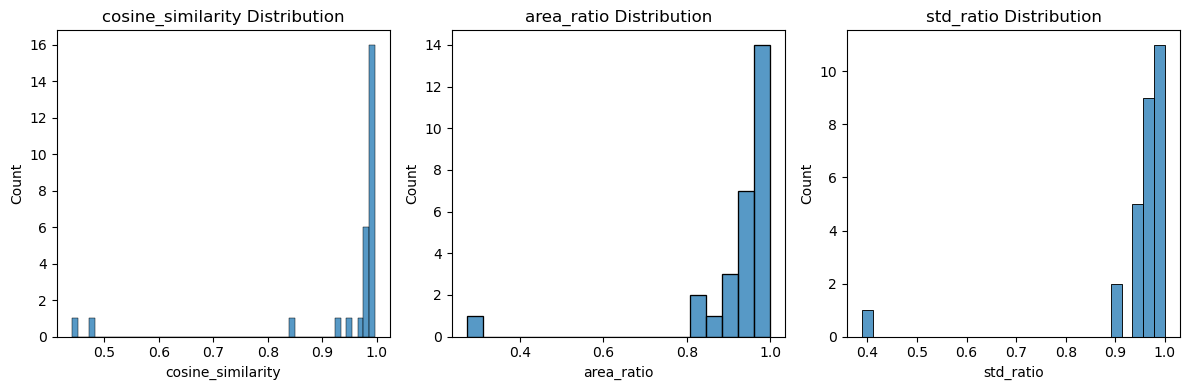


CM2 Feature Distributions:


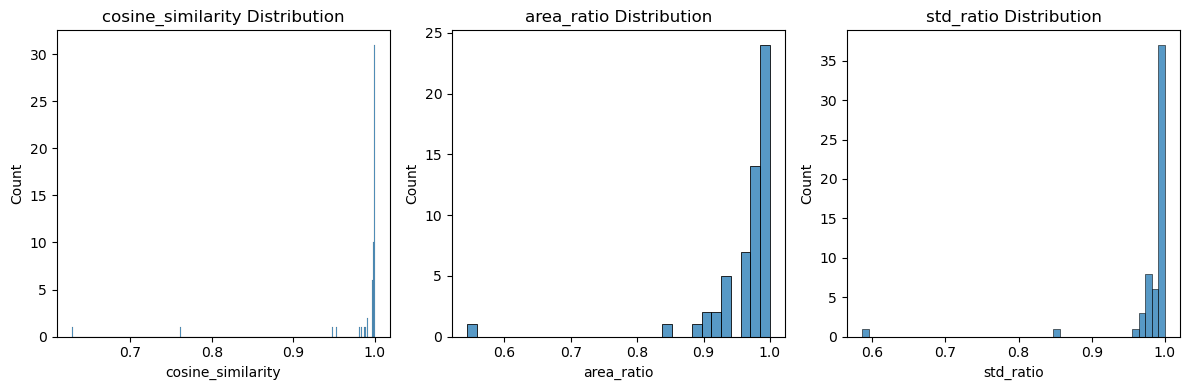


CM3 Feature Distributions:


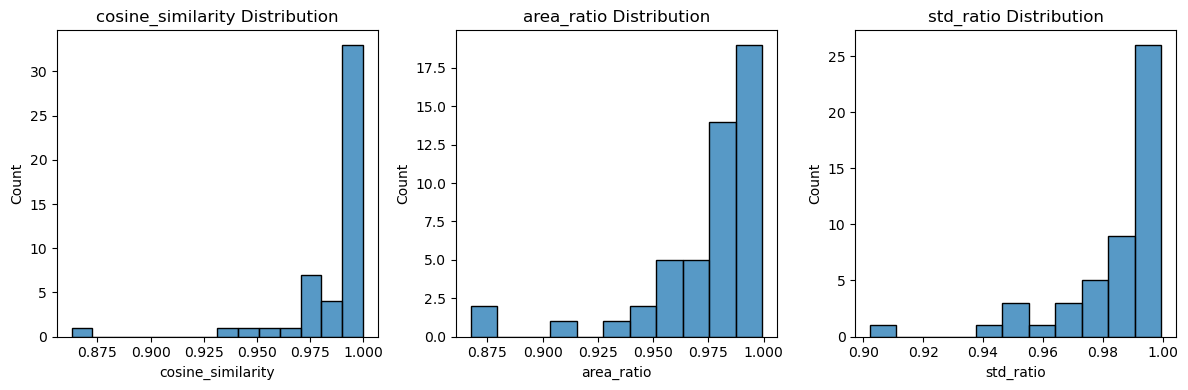

In [27]:
# Let's investigate feature distributions
def analyze_feature_distributions(dataset_path, compound_numbers):
    """Analyze feature distributions for a dataset"""
    all_features = []
    
    for compound in compound_numbers:
        # Get first two samples of each compound
        file1 = f"{dataset_path}/{compound:02d}-01.csv"
        file2 = f"{dataset_path}/{compound:02d}-02.csv"
        
        if os.path.exists(file1) and os.path.exists(file2):
            features = calculate_similarity_features(
                *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
            )
            if features:
                all_features.append(features)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features)
    
    # Plot distributions
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(df.columns):
        plt.subplot(1, len(df.columns), i+1)
        sns.histplot(data=df, x=col)
        plt.title(f'{col} Distribution')
    plt.tight_layout()
    plt.show()
    
    return df.describe()

# Analyze each dataset
cm1_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1'
cm2_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2'
cm3_path = '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'

print("CM1 Feature Distributions:")
cm1_stats = analyze_feature_distributions(cm1_path, range(1, 29))
print("\nCM2 Feature Distributions:")
cm2_stats = analyze_feature_distributions(cm2_path, range(1, 59))
print("\nCM3 Feature Distributions:")
cm3_stats = analyze_feature_distributions(cm3_path, range(1, 59))

Generating visualizations...


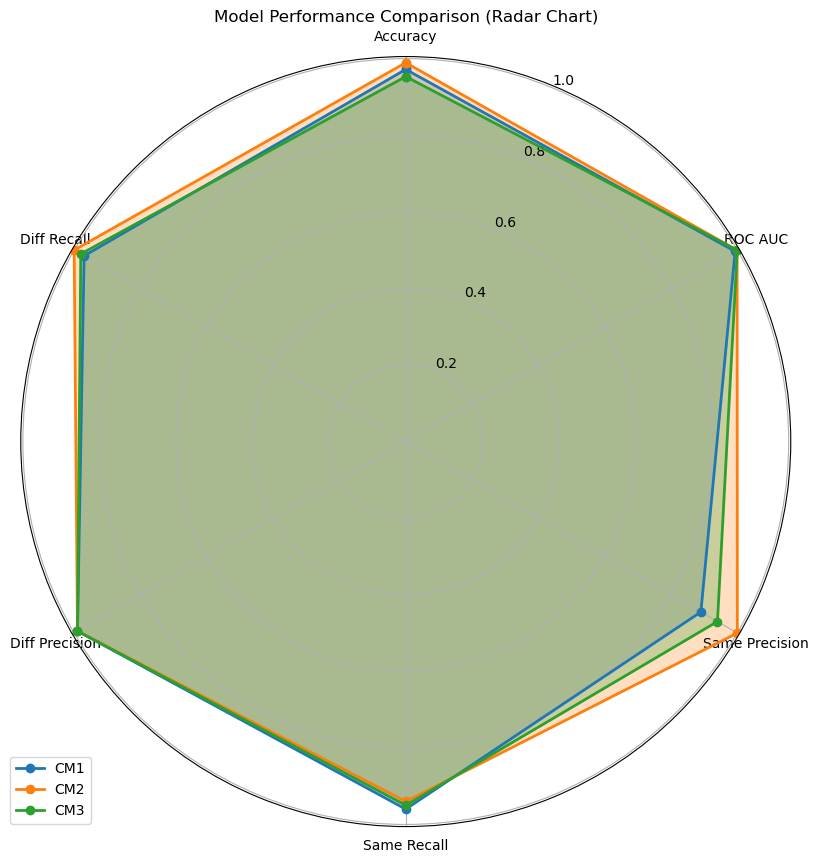

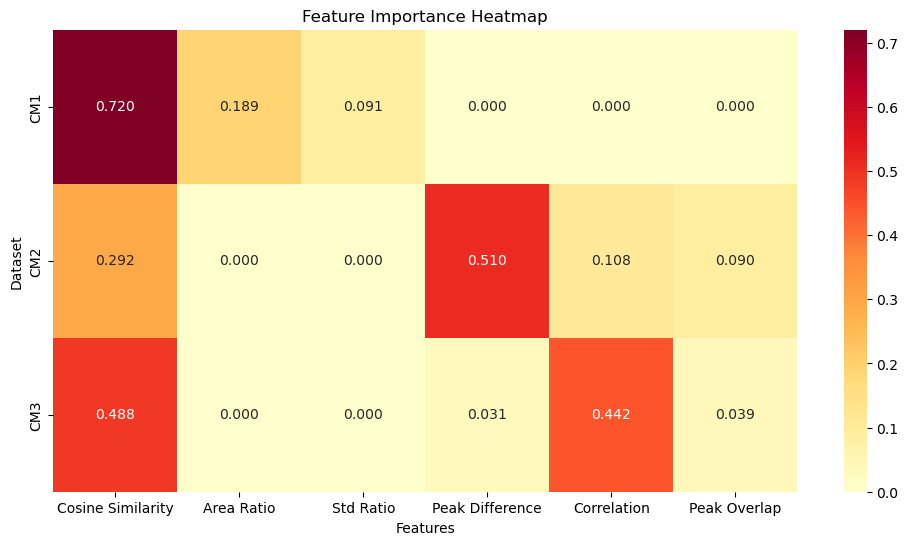

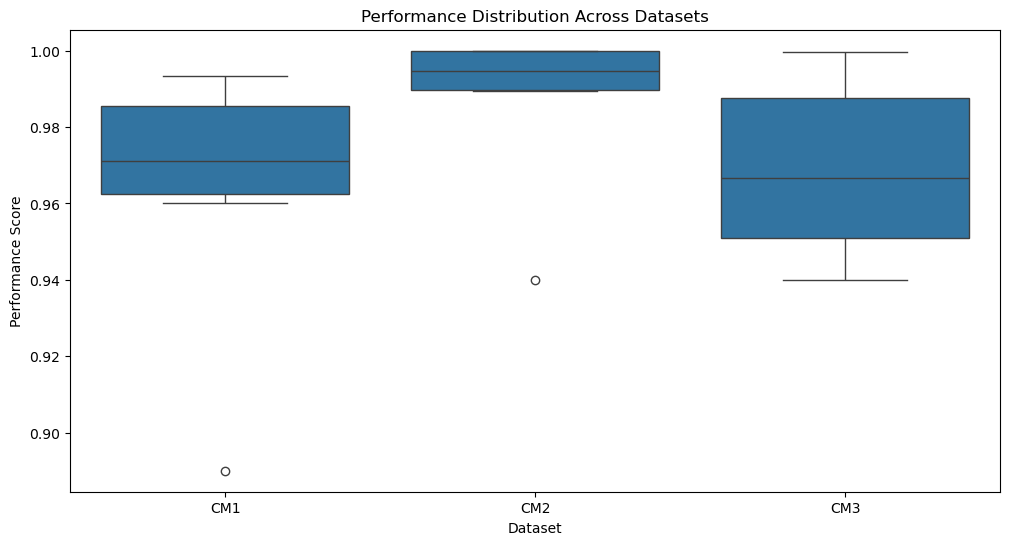

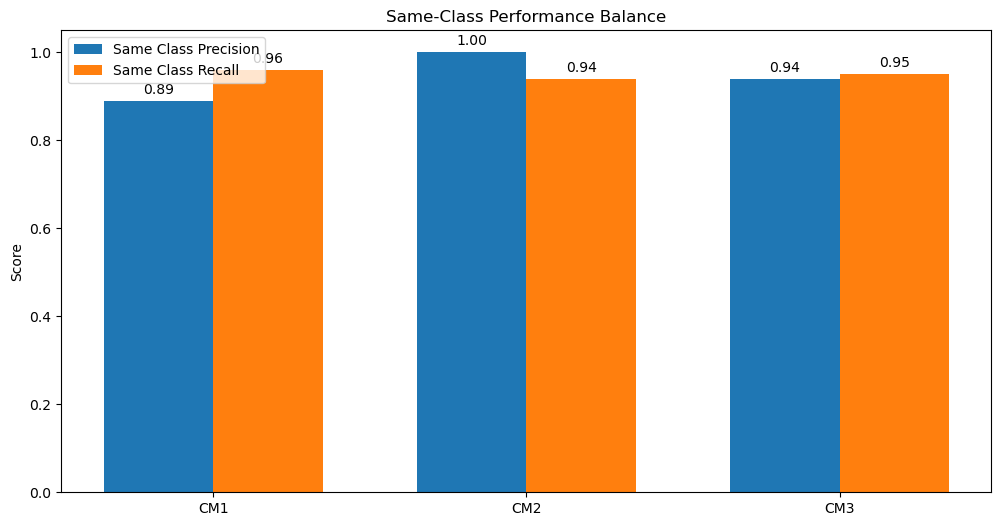

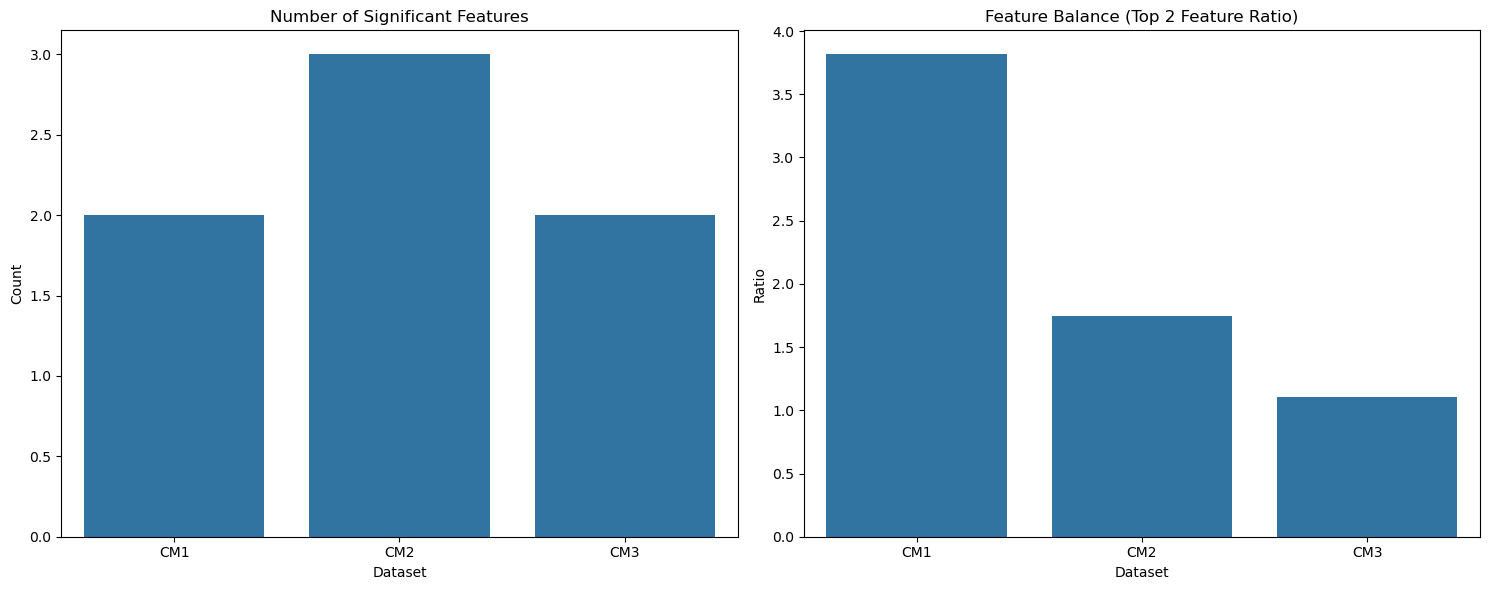

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Performance Metrics Radar Chart
def plot_radar_chart():
    # Metrics data
    metrics = {
        'CM1': [0.9720, 0.9934, 0.89, 0.96, 0.99, 0.97],
        'CM2': [0.9895, 0.9993, 1.00, 0.94, 0.99, 1.00],
        'CM3': [0.9533, 0.9997, 0.94, 0.95, 0.99, 0.98]
    }
    
    # Metrics labels
    categories = ['Accuracy', 'ROC AUC', 'Same Precision', 
                 'Same Recall', 'Diff Precision', 'Diff Recall']
    
    # Number of variables
    num_vars = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Plot data
    for dataset, values in metrics.items():
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=dataset)
        ax.fill(angles, values, alpha=0.25)
    
    # Fix axis to go in the right order and start at 12 o'clock
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    
    # Draw axis lines for each angle and label
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    
    # Add legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.title("Model Performance Comparison (Radar Chart)")
    plt.show()

# 2. Feature Importance Heatmap
def plot_feature_importance_heatmap():
    # Feature importance data
    feature_importance = {
        'CM1': {'Cosine Similarity': 0.7203, 'Area Ratio': 0.1888, 'Std Ratio': 0.0909,
                'Peak Difference': 0, 'Correlation': 0, 'Peak Overlap': 0},
        'CM2': {'Cosine Similarity': 0.2918, 'Area Ratio': 0, 'Std Ratio': 0,
                'Peak Difference': 0.5100, 'Correlation': 0.1078, 'Peak Overlap': 0.0904},
        'CM3': {'Cosine Similarity': 0.4884, 'Area Ratio': 0, 'Std Ratio': 0,
                'Peak Difference': 0.0309, 'Correlation': 0.4417, 'Peak Overlap': 0.0391}
    }
    
    # Create heatmap data
    importance_df = pd.DataFrame(feature_importance).T
    
    plt.figure(figsize=(12, 6))
    sns.heatmap(importance_df, annot=True, cmap='YlOrRd', fmt='.3f')
    plt.title('Feature Importance Heatmap')
    plt.ylabel('Dataset')
    plt.xlabel('Features')
    plt.show()

# 3. Performance Distribution
def plot_performance_distribution():
    # Create performance data
    performance_data = pd.DataFrame({
        'Dataset': ['CM1']*6 + ['CM2']*6 + ['CM3']*6,
        'Metric': ['Accuracy', 'ROC AUC', 'Same Prec', 'Same Rec', 'Diff Prec', 'Diff Rec']*3,
        'Value': [0.9720, 0.9934, 0.89, 0.96, 0.99, 0.97,
                 0.9895, 0.9993, 1.00, 0.94, 0.99, 1.00,
                 0.9533, 0.9997, 0.94, 0.95, 0.99, 0.98]
    })
    
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Dataset', y='Value', data=performance_data)
    plt.title('Performance Distribution Across Datasets')
    plt.ylabel('Performance Score')
    plt.show()

# 4. Balanced Performance Visualization
def plot_balanced_performance():
    # Data for balanced performance
    datasets = ['CM1', 'CM2', 'CM3']
    same_class = np.array([[0.89, 0.96], [1.00, 0.94], [0.94, 0.95]])  # [precision, recall]
    diff_class = np.array([[0.99, 0.97], [0.99, 1.00], [0.99, 0.98]])  # [precision, recall]
    
    x = np.arange(len(datasets))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(12, 6))
    rects1 = ax.bar(x - width/2, same_class[:, 0], width, label='Same Class Precision')
    rects2 = ax.bar(x + width/2, same_class[:, 1], width, label='Same Class Recall')
    
    ax.set_ylabel('Score')
    ax.set_title('Same-Class Performance Balance')
    ax.set_xticks(x)
    ax.set_xticklabels(datasets)
    ax.legend()
    
    # Add value labels
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                       xy=(rect.get_x() + rect.get_width() / 2, height),
                       xytext=(0, 3),
                       textcoords="offset points",
                       ha='center', va='bottom')
    
    autolabel(rects1)
    autolabel(rects2)
    plt.show()

# 5. Model Complexity Visualization
def plot_model_complexity():
    # Number of significant features (importance > 0.1)
    complexity_data = pd.DataFrame({
        'Dataset': ['CM1', 'CM2', 'CM3'],
        'Significant_Features': [2, 3, 2],
        'Feature_Balance': [0.7203/0.1888, 0.5100/0.2918, 0.4884/0.4417]  # Ratio of top 2 features
    })
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Number of significant features
    sns.barplot(x='Dataset', y='Significant_Features', data=complexity_data, ax=ax1)
    ax1.set_title('Number of Significant Features')
    ax1.set_ylabel('Count')
    
    # Feature balance
    sns.barplot(x='Dataset', y='Feature_Balance', data=complexity_data, ax=ax2)
    ax2.set_title('Feature Balance (Top 2 Feature Ratio)')
    ax2.set_ylabel('Ratio')
    
    plt.tight_layout()
    plt.show()

# Generate all visualizations
print("Generating visualizations...")
plot_radar_chart()
plot_feature_importance_heatmap()
plot_performance_distribution()
plot_balanced_performance()
plot_model_complexity()

Generating combined comparisons...

Processing CM1...
Found 28 compounds in CM1
Processing CM1 compound 10
Processing CM1 compound 20

Processing CM2...
Found 57 compounds in CM2
Processing CM2 compound 10
Processing CM2 compound 20
Processing CM2 compound 30
Processing CM2 compound 40
Processing CM2 compound 50

Processing CM3...
Found 49 compounds in CM3
Processing CM3 compound 10
Processing CM3 compound 20
Processing CM3 compound 30
Processing CM3 compound 40

Combined Dataset Statistics:
Same compound comparisons: 1340
Different compound comparisons: 6475
Class balance ratio (same/diff): 0.21

Cross-validation scores: [0.97761791 0.96642686 0.972      0.9696     0.9776    ]
Mean CV score: 0.9726 (+/- 0.0088)

Training combined model...

Overall Performance:
Accuracy: 0.9725
ROC AUC: 0.9983

Overall Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1295
           1       0.87      0.99      0.92       268


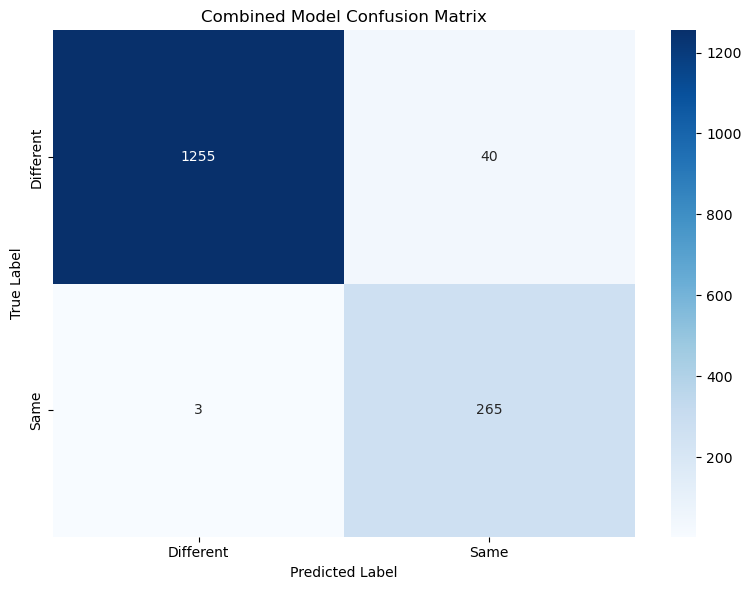

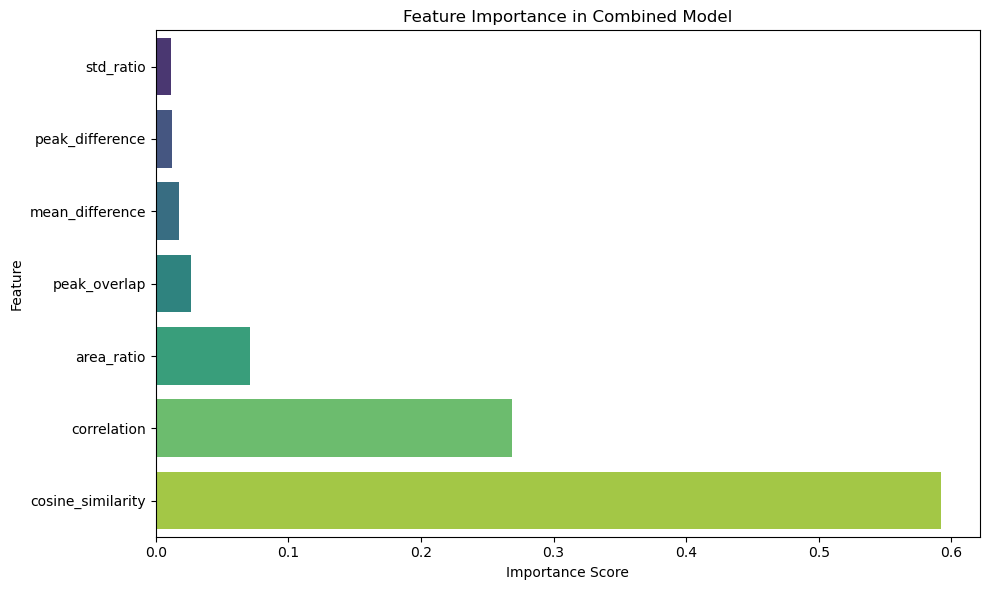


Feature Importance Rankings:
cosine_similarity    0.5920
correlation          0.2690
area_ratio           0.0711
peak_overlap         0.0265
mean_difference      0.0174
peak_difference      0.0124
std_ratio            0.0117

Combined model and scaler saved!


In [32]:
#combined model 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_similarity_features(mz, int1, int2):
    """Calculate similarity features between aligned spectra"""
    try:
        # Cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        # Correlation
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        # Peak analysis
        peak_threshold1 = np.mean(int1) + np.std(int1)
        peak_threshold2 = np.mean(int2) + np.std(int2)
        peaks1 = int1 > peak_threshold1
        peaks2 = int2 > peak_threshold2
        
        peak_overlap = np.sum(np.logical_and(peaks1, peaks2)) / len(mz)
        peak_diff = np.sum(np.logical_xor(peaks1, peaks2)) / len(mz)
        
        # Distribution measures
        mean_diff = abs(np.mean(int1) - np.mean(int2))
        std_ratio = min(np.std(int1)/np.std(int2), np.std(int2)/np.std(int1)) if np.std(int1) > 0 and np.std(int2) > 0 else 0
        
        # Area measures
        area1 = np.trapz(int1, mz)
        area2 = np.trapz(int2, mz)
        area_ratio = min(area1/area2, area2/area1) if area1 > 0 and area2 > 0 else 0
        
        features = {
            'cosine_similarity': cosine_sim,
            'correlation': correlation,
            'peak_overlap': peak_overlap,
            'peak_difference': peak_diff,
            'mean_difference': mean_diff,
            'std_ratio': std_ratio,
            'area_ratio': area_ratio
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def check_compound_existence(base_path, compound_num):
    """Check if a compound exists by looking for at least one valid file"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix with nice formatting"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Different', 'Same'],
                yticklabels=['Different', 'Same'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return cm

def generate_combined_comparisons(base_paths, debug=False):
    """Generate comparisons for all datasets combined"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    # Process each dataset
    for dataset_idx, base_path in enumerate(base_paths):
        dataset_name = f"CM{dataset_idx + 1}"
        if debug:
            print(f"\nProcessing {dataset_name}...")
        
        # Get number of compounds for this dataset
        max_compounds = 28 if dataset_idx == 0 else 58  # CM1 has 28, CM2/CM3 have 58
        
        # Identify existing compounds
        existing_compounds = []
        for compound_i in range(1, max_compounds + 1):
            if check_compound_existence(base_path, compound_i):
                existing_compounds.append(compound_i)
        
        if debug:
            print(f"Found {len(existing_compounds)} compounds in {dataset_name}")
        
        # Same compound comparisons
        for compound_i in existing_compounds:
            if debug and compound_i % 10 == 0:
                print(f"Processing {dataset_name} compound {compound_i}")
                
            for i in range(1, 5):
                for j in range(i + 1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                        
                    features = calculate_similarity_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(1)  # Same compound
                        comparisons.append((file1, file2))
                        same_count += 1
        
        # Different compound comparisons
        for idx, compound_i in enumerate(existing_compounds[:-1]):
            # Compare with next 2 compounds
            for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
                for i in range(1, 6):
                    for j in range(1, 6):
                        file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                        file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                        
                        if not os.path.exists(file1) or not os.path.exists(file2):
                            continue
                        
                        features = calculate_similarity_features(
                            *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                        )
                        
                        if features is not None:
                            X.append(list(features.values()))
                            y.append(0)  # Different compounds
                            comparisons.append((file1, file2))
                            diff_count += 1
    
    print("\nCombined Dataset Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def main():
    # Set paths for all datasets
    base_paths = [
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    ]
    
    # Generate combined comparisons
    print("Generating combined comparisons...")
    X, y, comparisons = generate_combined_comparisons(base_paths, debug=True)
    
    if X is not None:
        # Split and scale the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        # Create model with optimized parameters
        model = xgb.XGBClassifier(
            max_depth=4,
            min_child_weight=2,
            gamma=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            learning_rate=0.005,
            n_estimators=300,
            scale_pos_weight=4,
            reg_lambda=0.8,
            reg_alpha=0.1,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        # Cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train model
        print("\nTraining combined model...")
        model.fit(X_train_scaled, y_train)
        
        # Evaluate overall performance
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nOverall Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nOverall Classification Report:")
        print(classification_report(y_test, y_pred))
        
        # Plot overall confusion matrix
        print("\nOverall Confusion Matrix:")
        plot_confusion_matrix(y_test, y_pred, "Combined Model Confusion Matrix")
        
        # Feature importance analysis
        feature_names = ['cosine_similarity', 'correlation', 'peak_overlap', 
                        'peak_difference', 'mean_difference', 'std_ratio', 'area_ratio']
        importance = model.feature_importances_
        
        plt.figure(figsize=(10, 6))
        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
        plt.title('Feature Importance in Combined Model')
        plt.xlabel('Importance Score')
        plt.tight_layout()
        plt.show()
        
        print("\nFeature Importance Rankings:")
        for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
            print(f"{name:20} {imp:.4f}")
        
        # Save combined model
        try:
            model.save_model('combined_model.json')
            joblib.dump(scaler, 'combined_scaler.joblib')
            print("\nCombined model and scaler saved!")
        except Exception as e:
            print(f"Error saving model: {str(e)}")

if __name__ == "__main__":
    main()

Generating combined comparisons with top features...

Processing CM1...
Found 28 compounds in CM1
Processing CM1 compound 10
Processing CM1 compound 20

Processing CM2...
Found 57 compounds in CM2
Processing CM2 compound 10
Processing CM2 compound 20
Processing CM2 compound 30
Processing CM2 compound 40
Processing CM2 compound 50

Processing CM3...
Found 49 compounds in CM3
Processing CM3 compound 10
Processing CM3 compound 20
Processing CM3 compound 30
Processing CM3 compound 40

Combined Dataset Statistics:
Same compound comparisons: 1340
Different compound comparisons: 6475
Class balance ratio (same/diff): 0.21

Cross-validation scores: [0.97841727 0.9656275  0.9688     0.9672     0.9736    ]
Mean CV score: 0.9707 (+/- 0.0094)

Training model with top features...

Model Performance (Top Features):
Accuracy: 0.9674
ROC AUC: 0.9953

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1295
           1       0.8

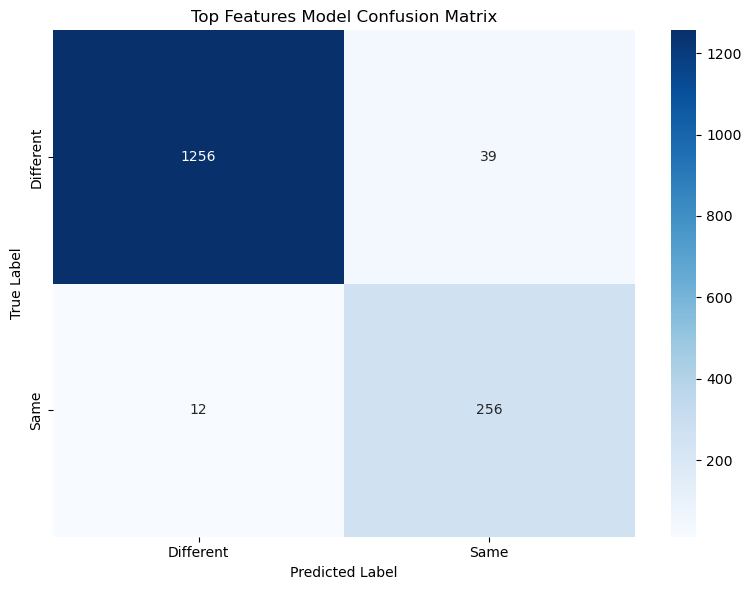


Feature Importance Rankings:
cosine_similarity    0.5417
correlation          0.3999
area_ratio           0.0584

Model and scaler saved!


In [33]:
#  model with top 3 features 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

# Keep the load_spectrum and align_spectra functions unchanged
def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_top_features(mz, int1, int2):
    """Calculate only the top 3 most important similarity features"""
    try:
        # Cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        # Correlation
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        # Area measures
        area1 = np.trapz(int1, mz)
        area2 = np.trapz(int2, mz)
        area_ratio = min(area1/area2, area2/area1) if area1 > 0 and area2 > 0 else 0
        
        features = {
            'cosine_similarity': cosine_sim,
            'correlation': correlation,
            'area_ratio': area_ratio
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def check_compound_existence(base_path, compound_num):
    """Check if a compound exists by looking for at least one valid file"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix with nice formatting"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Different', 'Same'],
                yticklabels=['Different', 'Same'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return cm

def generate_combined_comparisons(base_paths, debug=False):
    """Generate comparisons using only top features"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    for dataset_idx, base_path in enumerate(base_paths):
        dataset_name = f"CM{dataset_idx + 1}"
        if debug:
            print(f"\nProcessing {dataset_name}...")
        
        max_compounds = 28 if dataset_idx == 0 else 58
        
        existing_compounds = []
        for compound_i in range(1, max_compounds + 1):
            if check_compound_existence(base_path, compound_i):
                existing_compounds.append(compound_i)
        
        if debug:
            print(f"Found {len(existing_compounds)} compounds in {dataset_name}")
        
        # Same compound comparisons
        for compound_i in existing_compounds:
            if debug and compound_i % 10 == 0:
                print(f"Processing {dataset_name} compound {compound_i}")
                
            for i in range(1, 5):
                for j in range(i + 1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                        
                    features = calculate_top_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(1)
                        comparisons.append((file1, file2))
                        same_count += 1
        
        # Different compound comparisons
        for idx, compound_i in enumerate(existing_compounds[:-1]):
            for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
                for i in range(1, 6):
                    for j in range(1, 6):
                        file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                        file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                        
                        if not os.path.exists(file1) or not os.path.exists(file2):
                            continue
                        
                        features = calculate_top_features(
                            *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                        )
                        
                        if features is not None:
                            X.append(list(features.values()))
                            y.append(0)
                            comparisons.append((file1, file2))
                            diff_count += 1
    
    print("\nCombined Dataset Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def main():
    base_paths = [
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    ]
    
    print("Generating combined comparisons with top features...")
    X, y, comparisons = generate_combined_comparisons(base_paths, debug=True)
    
    if X is not None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model = xgb.XGBClassifier(
            max_depth=4,
            min_child_weight=2,
            gamma=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            learning_rate=0.005,
            n_estimators=300,
            scale_pos_weight=4,
            reg_lambda=0.8,
            reg_alpha=0.1,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        print("\nTraining model with top features...")
        model.fit(X_train_scaled, y_train)
        
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
        
        print("\nModel Performance (Top Features):")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        print("\nConfusion Matrix:")
        plot_confusion_matrix(y_test, y_pred, "Top Features Model Confusion Matrix")
        
        feature_names = ['cosine_similarity', 'correlation', 'area_ratio']
        importance = model.feature_importances_
        
        print("\nFeature Importance Rankings:")
        for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
            print(f"{name:20} {imp:.4f}")
        
        try:
            model.save_model('top_features_model.json')
            joblib.dump(scaler, 'top_features_scaler.joblib')
            print("\nModel and scaler saved!")
        except Exception as e:
            print(f"Error saving model: {str(e)}")

if __name__ == "__main__":
    main()

Generating dataset with top 2 features...

Processing CM1...
Found 28 compounds in CM1
Processing CM1 compound 10
Processing CM1 compound 20

Processing CM2...
Found 57 compounds in CM2
Processing CM2 compound 10
Processing CM2 compound 20
Processing CM2 compound 30
Processing CM2 compound 40
Processing CM2 compound 50

Processing CM3...
Found 49 compounds in CM3
Processing CM3 compound 10
Processing CM3 compound 20
Processing CM3 compound 30
Processing CM3 compound 40


[I 2024-10-24 22:30:02,632] A new study created in memory with name: no-name-448edfbb-4005-48b2-bb38-5075662ddb26



Combined Dataset Statistics:
Same compound comparisons: 1340
Different compound comparisons: 6475
Class balance ratio (same/diff): 0.21

Optimizing hyperparameters...


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-10-24 22:30:02,908] Trial 0 finished with value: 0.9883403446090012 and parameters: {'max_depth': 3, 'min_child_weight': 4.802857225639665, 'gamma': 0.3686770314875885, 'subsample': 0.8394633936788146, 'colsample_bytree': 0.6624074561769746, 'learning_rate': 0.002051110418843397, 'n_estimators': 123, 'scale_pos_weight': 5.330880728874676, 'reg_lambda': 1.2062188733689856, 'reg_alpha': 1.4190644298141306}. Best is trial 0 with value: 0.9883403446090012.
[I 2024-10-24 22:30:03,062] Trial 1 finished with value: 0.9875658387598685 and parameters: {'max_depth': 2, 'min_child_weight': 4.879639408647977, 'gamma': 0.41789689399220664, 'subsample': 0.6849356442713105, 'colsample_bytree': 0.6727299868828402, 'learning_rate': 0.002327067708383781, 'n_estimators': 222, 'scale_pos_weight': 3.6237821581611893, 'reg_lambda': 0.8695705870978103, 'reg_alpha': 0.5895459889941034}. Best is trial 0 with value: 0.9883403446090012.
[I 2024-10-24 22:30:03,276] Trial 2 finished with value: 0.991859332

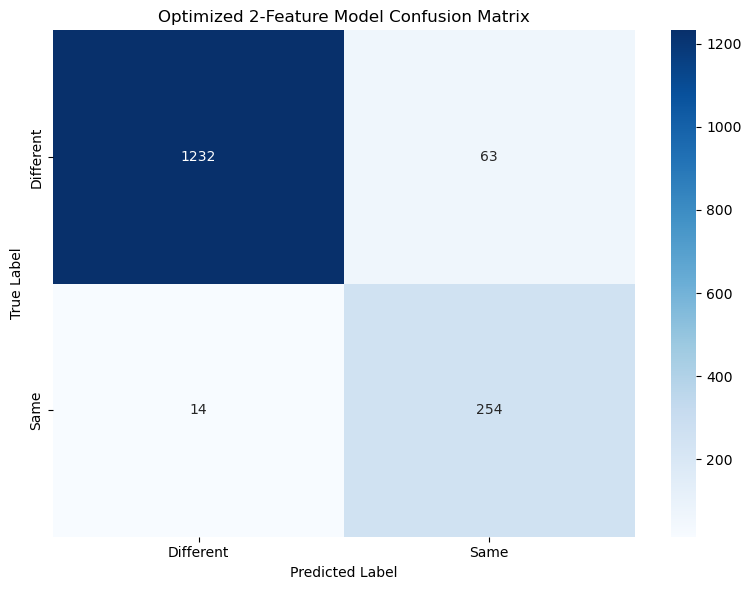


Feature Importance Rankings:
cosine_similarity    0.5842
correlation          0.4158


<Figure size 1000x600 with 0 Axes>

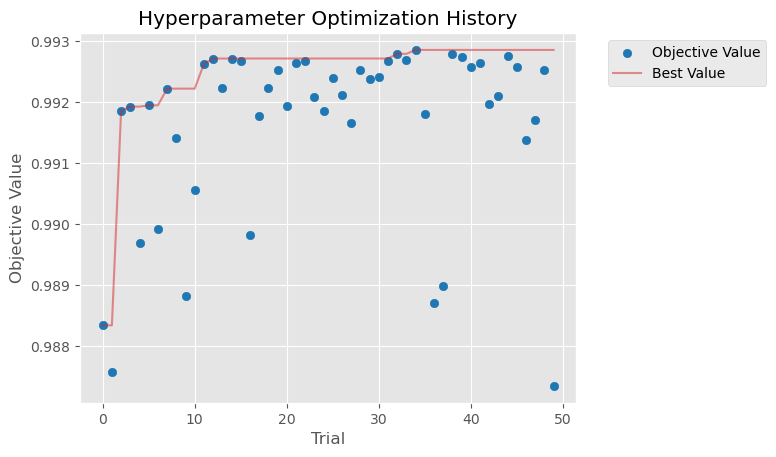

<Figure size 1000x600 with 0 Axes>

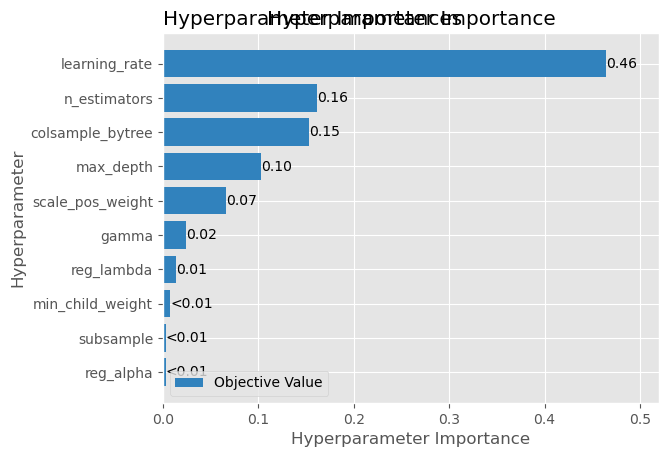

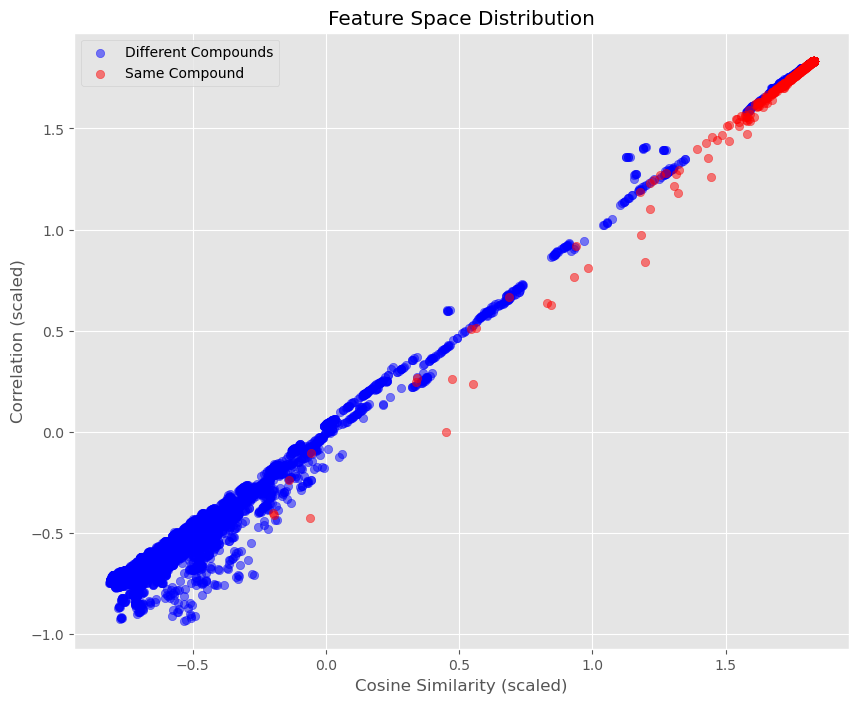


Optimized model and scaler saved!


In [35]:
# combined model with optuna and top 2 features

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from optuna.samplers import TPESampler
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

def load_spectrum(filepath):
    """Load mass spectrum from CSV file"""
    try:
        spectrum = pd.read_csv(filepath, skiprows=1)
        mz = spectrum['X(Thompsons)'].values
        intensities = spectrum['Y(Counts)'].values
        return mz, intensities
    except Exception as e:
        if 'skiprows' not in str(e):
            print(f"Error loading {filepath}: {str(e)}")
        return None, None

def align_spectra(mz1, intensities1, mz2, intensities2, n_points=1000):
    """Align two spectra to a common m/z axis using interpolation"""
    try:
        # Define common m/z range
        min_mz = max(np.min(mz1), np.min(mz2))
        max_mz = min(np.max(mz1), np.max(mz2))
        
        # Create common m/z axis
        common_mz = np.linspace(min_mz, max_mz, n_points)
        
        # Create interpolation functions
        f1 = interp1d(mz1, intensities1, kind='linear', bounds_error=False, fill_value=0)
        f2 = interp1d(mz2, intensities2, kind='linear', bounds_error=False, fill_value=0)
        
        # Interpolate intensities
        int1_aligned = f1(common_mz)
        int2_aligned = f2(common_mz)
        
        # Normalize intensities
        max_int1 = np.max(int1_aligned)
        max_int2 = np.max(int2_aligned)
        
        if max_int1 > 0:
            int1_aligned = int1_aligned / max_int1
        if max_int2 > 0:
            int2_aligned = int2_aligned / max_int2
        
        return common_mz, int1_aligned, int2_aligned
        
    except Exception as e:
        print(f"Error aligning spectra: {str(e)}")
        return None, None, None

def calculate_top_features(mz, int1, int2):
    """Calculate only the top 2 most important similarity features"""
    try:
        # Cosine similarity
        cosine_sim = np.dot(int1, int2) / (np.linalg.norm(int1) * np.linalg.norm(int2))
        
        # Correlation
        correlation = np.corrcoef(int1, int2)[0, 1]
        
        features = {
            'cosine_similarity': cosine_sim,
            'correlation': correlation
        }
        
        # Validate features
        if not all(np.isfinite(v) for v in features.values()):
            return None
            
        return features
        
    except Exception as e:
        print(f"Error calculating features: {str(e)}")
        return None

def check_compound_existence(base_path, compound_num):
    """Check if a compound exists by looking for at least one valid file"""
    for i in range(1, 11):
        if os.path.exists(f"{base_path}/{compound_num:02d}-{i:02d}.csv"):
            return True
    return False

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    """Plot confusion matrix with nice formatting"""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Different', 'Same'],
                yticklabels=['Different', 'Same'])
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    return cm

def generate_combined_comparisons(base_paths, debug=False):
    """Generate comparisons using only top features"""
    X = []
    y = []
    comparisons = []
    same_count = 0
    diff_count = 0
    
    for dataset_idx, base_path in enumerate(base_paths):
        dataset_name = f"CM{dataset_idx + 1}"
        if debug:
            print(f"\nProcessing {dataset_name}...")
        
        max_compounds = 28 if dataset_idx == 0 else 58
        
        existing_compounds = []
        for compound_i in range(1, max_compounds + 1):
            if check_compound_existence(base_path, compound_i):
                existing_compounds.append(compound_i)
        
        if debug:
            print(f"Found {len(existing_compounds)} compounds in {dataset_name}")
        
        # Same compound comparisons
        for compound_i in existing_compounds:
            if debug and compound_i % 10 == 0:
                print(f"Processing {dataset_name} compound {compound_i}")
                
            for i in range(1, 5):
                for j in range(i + 1, 6):
                    file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                    file2 = f"{base_path}/{compound_i:02d}-{j:02d}.csv"
                    
                    if not os.path.exists(file1) or not os.path.exists(file2):
                        continue
                        
                    features = calculate_top_features(
                        *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                    )
                    
                    if features is not None:
                        X.append(list(features.values()))
                        y.append(1)
                        comparisons.append((file1, file2))
                        same_count += 1
        
        # Different compound comparisons
        for idx, compound_i in enumerate(existing_compounds[:-1]):
            for compound_j in existing_compounds[idx+1:min(idx+3, len(existing_compounds))]:
                for i in range(1, 6):
                    for j in range(1, 6):
                        file1 = f"{base_path}/{compound_i:02d}-{i:02d}.csv"
                        file2 = f"{base_path}/{compound_j:02d}-{j:02d}.csv"
                        
                        if not os.path.exists(file1) or not os.path.exists(file2):
                            continue
                        
                        features = calculate_top_features(
                            *align_spectra(*load_spectrum(file1), *load_spectrum(file2))
                        )
                        
                        if features is not None:
                            X.append(list(features.values()))
                            y.append(0)
                            comparisons.append((file1, file2))
                            diff_count += 1
    
    print("\nCombined Dataset Statistics:")
    print(f"Same compound comparisons: {same_count}")
    print(f"Different compound comparisons: {diff_count}")
    print(f"Class balance ratio (same/diff): {same_count/diff_count:.2f}")
    
    return np.array(X), np.array(y), comparisons

def create_model(trial):
    """Create XGBoost model with hyperparameters suggested by Optuna"""
    return xgb.XGBClassifier(
        max_depth=trial.suggest_int('max_depth', 2, 6),
        min_child_weight=trial.suggest_float('min_child_weight', 1, 5),
        gamma=trial.suggest_float('gamma', 0.01, 0.5),
        subsample=trial.suggest_float('subsample', 0.6, 1.0),
        colsample_bytree=trial.suggest_float('colsample_bytree', 0.6, 1.0),
        learning_rate=trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        scale_pos_weight=trial.suggest_float('scale_pos_weight', 1, 6),
        reg_lambda=trial.suggest_float('reg_lambda', 0.01, 2.0),
        reg_alpha=trial.suggest_float('reg_alpha', 0.01, 2.0),
        objective='binary:logistic',
        random_state=42,
        use_label_encoder=False
    )

def objective(trial, X, y):
    """Optuna objective function"""
    model = create_model(trial)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')
    return scores.mean()

def main():
    base_paths = [
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM1',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM2',
        '/Users/ajibolaoluwatobiloba/Desktop/Mass spectra project/minmax_SourceAndData/C-ComputingIndices/CosineSimilarity/CM3'
    ]
    
    print("Generating dataset with top 2 features...")
    X, y, _ = generate_combined_comparisons(base_paths, debug=True)
    
    if X is not None:
        # Scale features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Create and run Optuna study
        study = optuna.create_study(
            direction="maximize",
            sampler=TPESampler(seed=42),
            pruner=optuna.pruners.MedianPruner()
        )
        
        print("\nOptimizing hyperparameters...")
        study.optimize(
            lambda trial: objective(trial, X_scaled, y),
            n_trials=50,
            show_progress_bar=True
        )
        
        # Get best parameters
        best_params = study.best_params
        print("\nBest hyperparameters:")
        for param, value in best_params.items():
            print(f"{param:20} {value}")
        
        print(f"\nBest ROC AUC: {study.best_value:.4f}")
        
        # Train final model with best parameters
        print("\nTraining final model with optimized parameters...")
        best_model = xgb.XGBClassifier(
            **best_params,
            objective='binary:logistic',
            random_state=42,
            use_label_encoder=False
        )
        
        # Evaluate with cross-validation
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        cv_scores = cross_val_score(best_model, X_scaled, y, cv=cv, scoring='accuracy')
        
        print("\nCross-validation scores:", cv_scores)
        print(f"Mean CV score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
        
        # Train and evaluate final model
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.2, random_state=42, stratify=y
        )
        
        best_model.fit(X_train, y_train)
        y_pred = best_model.predict(X_test)
        y_prob = best_model.predict_proba(X_test)[:, 1]
        
        print("\nFinal Model Performance:")
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))
        
        print("\nConfusion Matrix:")
        plot_confusion_matrix(y_test, y_pred, "Optimized 2-Feature Model Confusion Matrix")
        
        feature_names = ['cosine_similarity', 'correlation']
        importance = best_model.feature_importances_
        
        print("\nFeature Importance Rankings:")
        for name, imp in sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True):
            print(f"{name:20} {imp:.4f}")
        
        # Plot optimization history
        plt.figure(figsize=(10, 6))
        optuna.visualization.matplotlib.plot_optimization_history(study)
        plt.title('Hyperparameter Optimization History')
        plt.show()
        
        # Plot parameter importances
        plt.figure(figsize=(10, 6))
        optuna.visualization.matplotlib.plot_param_importances(study)
        plt.title('Hyperparameter Importance')
        plt.show()
        
        # Create scatter plot of the two features
        plt.figure(figsize=(10, 8))
        plt.scatter(X_scaled[y==0, 0], X_scaled[y==0, 1], alpha=0.5, label='Different Compounds', c='blue')
        plt.scatter(X_scaled[y==1, 0], X_scaled[y==1, 1], alpha=0.5, label='Same Compound', c='red')
        plt.xlabel('Cosine Similarity (scaled)')
        plt.ylabel('Correlation (scaled)')
        plt.title('Feature Space Distribution')
        plt.legend()
        plt.grid(True)
        plt.show()
        
        try:
            best_model.save_model('optimized_two_features_model.json')
            joblib.dump(scaler, 'optimized_two_features_scaler.joblib')
            print("\nOptimized model and scaler saved!")
        except Exception as e:
            print(f"Error saving model: {str(e)}")

if __name__ == "__main__":
    main()